# TensorFlow Tutorial #03-C
# Keras API

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

## Introduction

Tutorial #02 showed how to implement a Convolutional Neural Network in TensorFlow. We made a few helper-functions for creating the layers in the network. It is essential to have a good high-level API because it makes it much easier to implement complex models, and it lowers the risk of errors.

There are several of these builder API's available for TensorFlow: PrettyTensor (Tutorial #03), Layers API (Tutorial #03-B), and several others. But they were never really finished and now they seem to be more or less abandoned by their developers.

This tutorial is about the Keras API which is already highly developed with very good documentation - and the development continues. It seems likely that Keras will be the standard API for TensorFlow in the future so it is recommended that you use it instead of the other APIs.

The author of Keras has written a [blog-post](https://blog.keras.io/user-experience-design-for-apis.html) on his API design philosophy which you should read.

## Flowchart

The following chart shows roughly how the data flows in the Convolutional Neural Network that is implemented below. See Tutorial #02 for a more detailed description of convolution.

There are two convolutional layers, each followed by a down-sampling using max-pooling (not shown in this flowchart). Then there are two fully-connected layers ending in a softmax-classifier.

![Flowchart](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/images/02_network_flowchart.png?raw=1)

## Imports

In [701]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math

We need to import several things from Keras. Note the long import-statements. This might be a bug. Hopefully it will be possible to write shorter and more elegant lines in the future.

In [702]:
# from tf.keras.models import Sequential  # This does not work!
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten

This was developed using Python 3.6 (Anaconda) and TensorFlow version:

In [703]:
tf.__version__

'1.9.0-rc2'

In [704]:
tf.keras.__version__

'2.1.6-tf'

## Load Data

The MNIST data-set is about 12 MB and will be downloaded automatically if it is not located in the given path.

In [705]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


The MNIST data-set has now been loaded and consists of 70,000 images and associated labels (i.e. classifications of the images). The data-set is split into 3 mutually exclusive sub-sets. We will only use the training and test-sets in this tutorial.

In [706]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


The class-labels are One-Hot encoded, which means that each label is a vector with 10 elements, all of which are zero except for one element. The index of this one element is the class-number, that is, the digit shown in the associated image. We also need the class-numbers as integers for the test-set, so we calculate it now.

In [707]:
data.test.cls = np.argmax(data.test.labels, axis=1)

## Data Dimensions

The data dimensions are used in several places in the source-code below. They are defined once so we can use these variables instead of numbers throughout the source-code below.

In [708]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
# This is used for plotting the images.
img_shape = (img_size, img_size)

# Tuple with height, width and depth used to reshape arrays.
# This is used for reshaping in Keras.
img_shape_full = (img_size, img_size, 1)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

### Helper-function for plotting images

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [709]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Plot a few images to see if data is correct

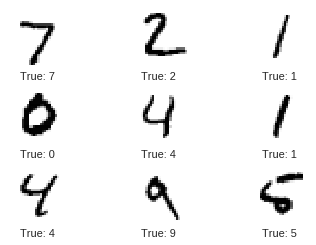

In [710]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

### Helper-function to plot example errors

Function for plotting examples of images from the test-set that have been mis-classified.

In [711]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != data.test.cls)

    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

## PrettyTensor API

This is how the Convolutional Neural Network was implemented in Tutorial #03 using the PrettyTensor API. It is shown here for easy comparison to the Keras implementation below.

In [712]:
if False:
    x_pretty = pt.wrap(x_image)

    with pt.defaults_scope(activation_fn=tf.nn.relu):
        y_pred, loss = x_pretty.\
            conv2d(kernel=5, depth=16, name='layer_conv1').\
            max_pool(kernel=2, stride=2).\
            conv2d(kernel=5, depth=36, name='layer_conv2').\
            max_pool(kernel=2, stride=2).\
            flatten().\
            fully_connected(size=128, name='layer_fc1').\
            softmax_classifier(num_classes=num_classes, labels=y_true)

## Sequential Model

The Keras API has two modes of constructing Neural Networks. The simplest is the Sequential Model which only allows for the layers to be added in sequence.

In [713]:
# Start construction of the Keras Sequential model.
model = Sequential()

# Add an input layer which is similar to a feed_dict in TensorFlow.
# Note that the input-shape must be a tuple containing the image-size.
model.add(InputLayer(input_shape=(img_size_flat,)))

# The input is a flattened array with 784 elements,
# but the convolutional layers expect images with shape (28, 28, 1)
model.add(Reshape(img_shape_full))

# First convolutional layer with ReLU-activation and max-pooling.
model.add(Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
                 activation='relu', name='layer_conv1'))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Second convolutional layer with ReLU-activation and max-pooling.
model.add(Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
                 activation='relu', name='layer_conv2'))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Flatten the 4-rank output of the convolutional layers
# to 2-rank that can be input to a fully-connected / dense layer.
model.add(Flatten())

# First fully-connected / dense layer with ReLU-activation.
model.add(Dense(128, activation='relu'))

# Last fully-connected / dense layer with softmax-activation
# for use in classification.
model.add(Dense(num_classes, activation='softmax'))

### Model Compilation

The Neural Network has now been defined and must be finalized by adding a loss-function, optimizer and performance metrics. This is called model "compilation" in Keras.

We can either define the optimizer using a string, or if we want more control of its parameters then we need to instantiate an object. For example, we can set the learning-rate.

In [714]:
from tensorflow.python.keras.optimizers import Adam

optimizer = Adam(lr=1e-3)

For a classification-problem such as MNIST which has 10 possible classes, we need to use the loss-function called `categorical_crossentropy`. The performance metric we are interested in is the classification accuracy.

In [715]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training

Now that the model has been fully defined with loss-function and optimizer, we can train it. This function takes numpy-arrays and performs the given number of training epochs using the given batch-size. An epoch is one full use of the entire training-set. So for 10 epochs we would iterate randomly over the entire training-set 10 times.

In [716]:
model.fit(x=data.train.images,
          y=data.train.labels,
          epochs=1, batch_size=128)

Epoch 1/1
55000/55000 [==============================] - 7s 126us/step - loss: 0.2134 - acc: 0.9383


### Evaluation

Now that the model has been trained we can test its performance on the test-set. This also uses numpy-arrays as input.

In [717]:
result = model.evaluate(x=data.test.images,
                        y=data.test.labels)

10000/10000 [==============================] - 1s 148us/step


We can print all the performance metrics for the test-set.

In [718]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.060762007527798416
acc 0.981


Or we can just print the classification accuracy.

In [719]:
print("{0}: {1:.2%}".format(model.metrics_names[1], result[1]))

acc: 98.10%


### Prediction

We can also predict the classification for new images. We will just use some images from the test-set but you could load your own images into numpy arrays and use those instead.

In [720]:
images = data.test.images[0:9]

These are the true class-number for those images. This is only used when plotting the images.

In [721]:
cls_true = data.test.cls[0:9]

Get the predicted classes as One-Hot encoded arrays.

In [722]:
y_pred = model.predict(x=images)

Get the predicted classes as integers.

In [723]:
cls_pred = np.argmax(y_pred,axis=1)

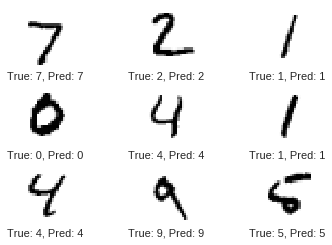

In [724]:
plot_images(images=images,
            cls_true=cls_true,
            cls_pred=cls_pred)

### Examples of Mis-Classified Images

We can plot some examples of mis-classified images from the test-set.

First we get the predicted classes for all the images in the test-set:

In [725]:
y_pred = model.predict(x=data.test.images)

Then we convert the predicted class-numbers from One-Hot encoded arrays to integers.

In [726]:
cls_pred = np.argmax(y_pred,axis=1)

Plot some of the mis-classified images.

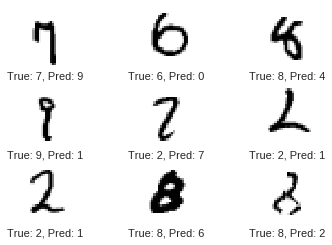

In [727]:
plot_example_errors(cls_pred)

## Functional Model

The Keras API can also be used to construct more complicated networks using the Functional Model. This may look a little confusing at first, because each call to the Keras API will create and return an instance that is itself callable. It is not clear whether it is a function or an object - but we can call it as if it is a function. This allows us to build computational graphs that are more complex than the Sequential Model allows.

In [728]:
from tensorflow.python.keras import backend as K
# Create an input layer which is similar to a feed_dict in TensorFlow.
# Note that the input-shape must be a tuple containing the image-size.
inputs = Input(shape=(img_size_flat,))

# Variable used for building the Neural Network.
net = inputs

# The input is an image as a flattened array with 784 elements.
# But the convolutional layers expect images with shape (28, 28, 1)
net = Reshape(img_shape_full)(net)

# First convolutional layer with ReLU-activation and max-pooling.
net = Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
             activation='relu', name='layer_conv1')(net)
net = MaxPooling2D(pool_size=2, strides=2)(net)

# Second convolutional layer with ReLU-activation and max-pooling.
net = Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
             activation='relu', name='layer_conv2')(net)
net = MaxPooling2D(pool_size=2, strides=2)(net)

# Flatten the output of the conv-layer from 4-dim to 2-dim.
net = Flatten()(net)

# First fully-connected / dense layer with ReLU-activation.
net = Dense(128, activation='relu')(net)

# Last fully-connected / dense layer with softmax-activation
# so it can be used for classification.
net = Dense(num_classes, activation='softmax')(net)
net = Dense(num_classes, activation='argmax')(net)


# Output of the Neural Network.
outputs = net

ValueError: ignored

### Model Compilation

We have now defined the architecture of the model with its input and output. We now have to create a Keras model and compile it with a loss-function and optimizer, so it is ready for training.

In [0]:
from tensorflow.python.keras.models import Model

Create a new instance of the Keras Functional Model. We give it the inputs and outputs of the Convolutional Neural Network that we constructed above.

In [0]:
model2 = Model(inputs=inputs, outputs=outputs)

Compile the Keras model using the `rmsprop` optimizer and with a loss-function for multiple categories. The only performance metric we are interested in is the classification accuracy, but you could use a list of metrics here.

In [0]:
model2.compile(optimizer='rmsprop',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

### Training

The model has now been defined and compiled so it can be trained using the same `fit()` function as used in the Sequential Model above. This also takes numpy-arrays as input.

In [0]:
model2.fit(x=data.train.images,
           y=data.train.labels,
           epochs=1, batch_size=128)

### Evaluation

Once the model has been trained we can evaluate its performance on the test-set. This is the same syntax as for the Sequential Model.

In [0]:
result = model2.evaluate(x=data.test.images,
                         y=data.test.labels)

The result is a list of values, containing the loss-value and all the metrics we defined when we compiled the model. Note that 'accuracy' is now called 'acc' which is a small inconsistency.

In [0]:
for name, value in zip(model2.metrics_names, result):
    print(name, value)

We can also print the classification accuracy as a percentage:

In [0]:
print("{0}: {1:.2%}".format(model2.metrics_names[1], result[1]))

### Examples of Mis-Classified Images

We can plot some examples of mis-classified images from the test-set.

First we get the predicted classes for all the images in the test-set:

In [0]:
y_pred = model2.predict(x=data.test.images)

Then we convert the predicted class-numbers from One-Hot encoded arrays to integers.

In [0]:
#cls_pred = np.argmax(y_pred, axis=1)

Plot some of the mis-classified images.

In [0]:
plot_example_errors(y_pred)

## Save & Load Model

NOTE: You need to install `h5py` for this to work!

Tutorial #04 was about saving and restoring the weights of a model using native TensorFlow code. It was an absolutely horrible API! Fortunately, Keras makes this very easy.

This is the file-path where we want to save the Keras model.

In [0]:
path_model = 'model.keras'

Saving a Keras model with the trained weights is then just a single function call, as it should be.

In [0]:
model2.save(path_model)

Delete the model from memory so we are sure it is no longer used.

In [0]:
del model2

We need to import this Keras function for loading the model.

In [0]:
from tensorflow.python.keras.models import load_model

Loading the model is then just a single function-call, as it should be.

In [0]:
model3 = load_model(path_model)

We can then use the model again e.g. to make predictions. We get the first 9 images from the test-set and their true class-numbers.

In [0]:
images = data.test.images[0:9]

In [0]:
cls_true = data.test.cls[0:9]

We then use the restored model to predict the class-numbers for those images.

In [0]:
y_pred = model3.predict(x=images)

Get the class-numbers as integers.

In [0]:
cls_pred = np.argmax(y_pred, axis=1)

Plot the images with their true and predicted class-numbers.

In [0]:
plot_images(images=images,
            cls_pred=cls_pred,
            cls_true=cls_true)

## Visualization of Layer Weights and Outputs

### Helper-function for plotting convolutional weights

In [0]:
def plot_conv_weights(weights, input_channel=0):
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(weights)
    w_max = np.max(weights)

    # Number of filters used in the conv. layer.
    num_filters = weights.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = weights[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Get Layers

Keras has a simple way of listing the layers in the model.

In [0]:
model3.summary()

We count the indices to get the layers we want.

The input-layer has index 0.

In [0]:
layer_input = model3.layers[0]

The first convolutional layer has index 2.

In [0]:
layer_conv1 = model3.layers[2]
layer_conv1

The second convolutional layer has index 4.

In [0]:
layer_conv2 = model3.layers[4]

### Convolutional Weights

Now that we have the layers we can easily get their weights.

In [0]:
weights_conv1 = layer_conv1.get_weights()[0]

This gives us a 4-rank tensor.

In [0]:
weights_conv1.shape

Plot the weights using the helper-function from above.

In [0]:
plot_conv_weights(weights=weights_conv1, input_channel=0)

We can also get the weights for the second convolutional layer and plot them.

In [0]:
weights_conv2 = layer_conv2.get_weights()[0]

In [0]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

### Helper-function for plotting the output of a convolutional layer

In [0]:
def plot_conv_output(values):
    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Input Image

Helper-function for plotting a single image.

In [0]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()

Plot an image from the test-set which will be used as an example below.

In [0]:
image1 = data.test.images[0]
plot_image(image1)

### Output of Convolutional Layer - Method 1

There are different ways of getting the output of a layer in a Keras model. This method uses a so-called K-function which turns a part of the Keras model into a function.

In [0]:
from tensorflow.python.keras import backend as K

In [0]:
output_conv1 = K.function(inputs=[layer_input.input],
                          outputs=[layer_conv1.output])

We can then call this function with the input image. Note that the image is wrapped in two lists because the function expects an array of that dimensionality. Likewise, the function returns an array with one more dimensionality than we want so we just take the first element.

In [0]:
layer_output1 = output_conv1([[image1]])[0]
layer_output1.shape

We can then plot the output of all 16 channels of the convolutional layer.

In [0]:
plot_conv_output(values=layer_output1)

### Output of Convolutional Layer - Method 2

Keras also has another method for getting the output of a layer inside the model. This creates another Functional Model using the same input as the original model, but the output is now taken from the convolutional layer that we are interested in.

In [0]:
output_conv2 = Model(inputs=layer_input.input,
                     outputs=layer_conv2.output)

This creates a new model-object where we can call the typical Keras functions. To get the output of the convoloutional layer we call the `predict()` function with the input image.

In [0]:
layer_output2 = output_conv2.predict(np.array([image1]))
layer_output2.shape

We can then plot the images for all 36 channels.

In [0]:
plot_conv_output(values=layer_output2)

## Conclusion

This tutorial showed how to use the so-called *Keras API* for easily building Convolutional Neural Networks in TensorFlow. Keras is by far the most complete and best designed API for TensorFlow.

This tutorial also showed how to use Keras to save and load a model, as well as getting the weights and outputs of convolutional layers.

It seems likely that Keras will be the standard API for TensorFlow in the future, for the simple reason that is already very good and it is constantly being improved. So it is recommended that you use Keras.

## Exercises

These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience with TensorFlow in order to learn how to use it properly.

You may want to backup this Notebook before making any changes.

* Train for more epochs. Does it improve the classification accuracy?
* Change the activation function to sigmoid for some of the layers.
* Can you find a simple way of changing the activation function for all the layers?
* Plot the output of the max-pooling layers instead of the conv-layers.
* Replace the 2x2 max-pooling layers with stride=2 in the convolutional layers. Is there a difference in classification accuracy? What if you optimize it again and again? The difference is random, so how would you measure if there really is a difference? What are the pros and cons of using max-pooling vs. stride in the conv-layer?
* Change the parameters for the layers, e.g. the kernel, depth, size, etc. What is the difference in time usage and classification accuracy?
* Add and remove some convolutional and fully-connected layers.
* What is the simplest network you can design that still performs well?
* Change the Functional Model so it has another convolutional layer that connects in parallel to the existing conv-layers before going into the dense layers.
* Change the Functional Model so it outputs the predicted class both as a One-Hot encoded array and as an integer, so we don't have to use `numpy.argmax()` afterwards.
* Remake the program yourself without looking too much at this source-code.
* Explain to a friend how the program works.

## License (MIT)

Copyright (c) 2016-2017 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.